## Project proposal
### Importing the dataset

In [22]:
install.packages("cowplot")
install.packages("kknn")
install.packages("GGally")
install.packages('tidyverse')
library(kknn)
library(GGally)


The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//Rtmp40wrHo/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//Rtmp40wrHo/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//Rtmp40wrHo/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//Rtmp40wrHo/downloaded_packages


In [28]:
#import libraries
install.packages("themis")
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(readxl)
library(ggplot2)
library(cowplot)


The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//Rtmp40wrHo/downloaded_packages


## Dataset background
- The dataset information can be found at: https://archive.ics.uci.edu/dataset/320/student+performance
## Questions for the dataset
- Mean final grade of students receiving extra support from school in comparison to students getting no support from school

## Import dataset

In [29]:
studenturl<- "https://archive.ics.uci.edu/static/public/320/student+performance.zip"
temp <- tempfile()
download.file(studenturl,temp)
studentzip <- unzip(temp, "student.zip")
studentfile <- unzip(studentzip,"student-por.csv")
student <- read_csv2(studentfile, col_names = TRUE)

student

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 649 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,F,18,U,GT3,T,1,1,other,other,⋯,1,1,1,1,1,5,6,11,12,9
MS,M,17,U,LE3,T,3,1,services,services,⋯,2,4,5,3,4,2,6,10,10,10
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,4,10,11,11


## Clean and wrangle dataset
- For this dataset, we will select the variable of interest, along with filtering out any data that is invalid (i.e NA)
- After that we will filter out the freetime after school information to be 3 and above (indicating high to very high free time)

In [49]:
clean_student <- student %>%
                  select(schoolsup,G3)%>%
                  filter(!is.na(schoolsup),!is.na(G3))
clean_student
summary_student <- clean_student %>%
                   group_by(schoolsup)%>%
                   summarize(mean_final_grade = mean(G3),
                            sd = sd(G3))
summary_student

schoolsup,G3
<chr>,<dbl>
yes,11
no,11
yes,12
⋮,⋮
no,9
no,10
no,11


schoolsup,mean_final_grade,sd
<chr>,<dbl>,<dbl>
no,11.97935,3.316040
yes,11.27941,2.304088


## Plot the raw data
- We will plot the final grade distribution for students receiving educational support and receiving no educational support

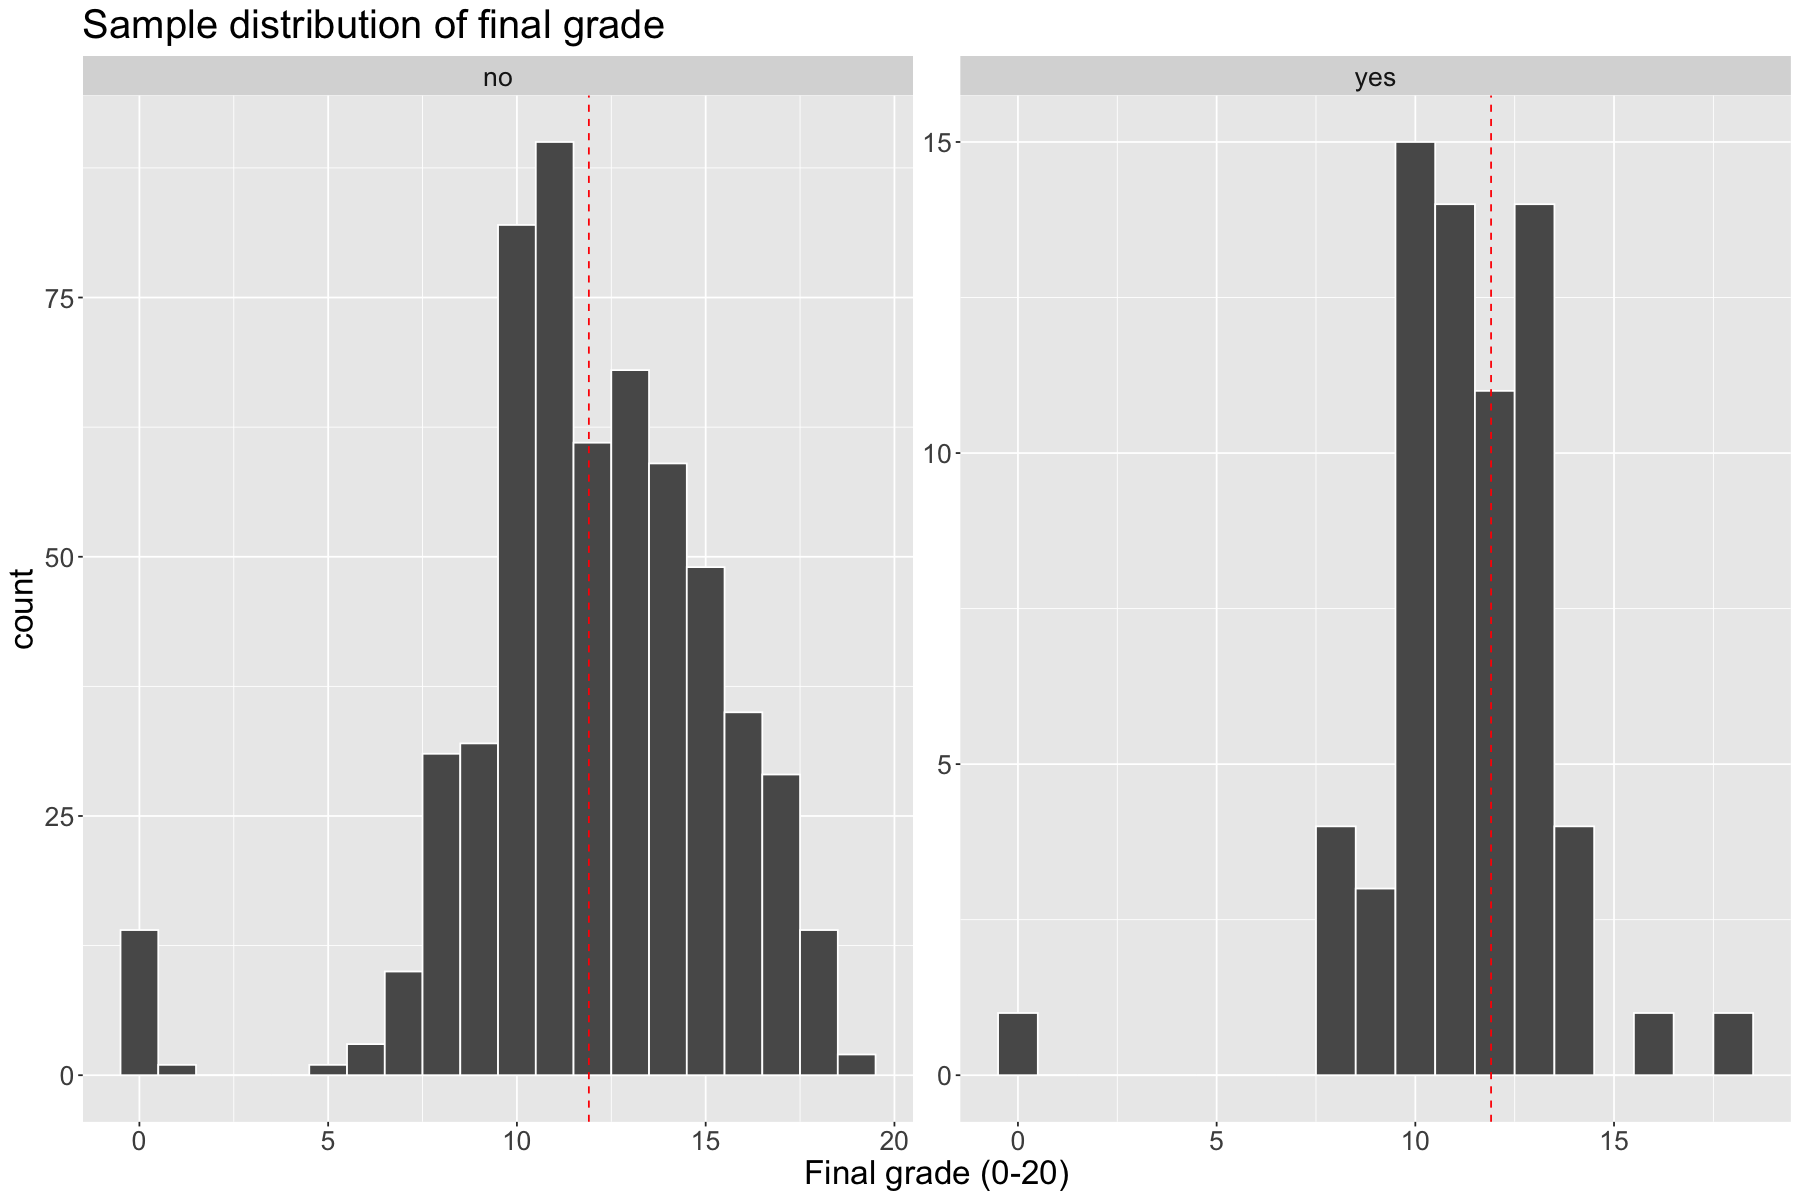

In [48]:
options(repr.plot.width = 15, repr.plot.height =10)
sample_distribution <- clean_student %>%
                       ggplot()+
                       geom_histogram(aes(G3),binwidth=1,,color="white")+
                       geom_vline(aes(xintercept=mean(G3)), color="red",
             linetype="dashed")+
                       ggtitle("Sample distribution of final grade")+
                       xlab("Final grade (0-20)")+
                       facet_wrap(vars(schoolsup),scales = "free")+
                       theme(text = element_text(size = 20))
sample_distribution